# 3D Tracking Competition

Based on http://localhost:8888/notebooks/demo_usage/competition_tracking_tutorial.ipynb

## A simple baseline

Here we will give an example of a very simple baseline based on clustering and simple heurstics. 

First, we will load up our tracking loader and map object

In [1]:
import copy
import numpy as np

import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

from argoverse.map_representation.map_api import ArgoverseMap

#path to argoverse tracking dataset test set, we will add our predicted labels into per_sweep_annotations_amodal/ 
#inside this folder
data_dir = '/data/argoai/downloads/argoverse-tracking/test/'

argoverse_loader = ArgoverseTrackingLoader(data_dir)

am = ArgoverseMap()


Here we will load up some example scene, including lidar point clouds for this particular scene.

In [2]:
#example scene
argoverse_data = argoverse_loader.get('9407efb5-5a87-30a9-b5f7-b517242f5a37')

#load up info
idx = 0
lidar_pts = argoverse_data.get_lidar(idx)
city_to_egovehicle_se3 = argoverse_data.get_pose(idx)
city_name = argoverse_data.city_name

In [3]:
print(f" frames: stereo camera {argoverse_data.num_stereo_camera_frame}, ring camera {argoverse_data.num_ring_camera_frame}, lidar {argoverse_data.num_lidar_frame}")

 frames: stereo camera 78, ring camera 466, lidar 156


Before we do anything else, we should first remove points that lie outside of region of interest (ROI). Additionally, we will also remove points that belong to the ground surface. Now the remaining points should be a lot more likely to be an object

In [4]:
roi_area_pts = copy.deepcopy(lidar_pts)
roi_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    roi_area_pts
)  # put into city coords
roi_area_pts = am.remove_non_roi_points(roi_area_pts, city_name)
roi_area_pts = am.remove_ground_surface(roi_area_pts, city_name)
roi_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    roi_area_pts
)
print(f"Started with {lidar_pts.shape}, ended with {roi_area_pts.shape}, f{roi_area_pts.shape[0]/lidar_pts.shape[0]:.3}")

Started with (91066, 3), ended with (71610, 3), f0.786


We can also further separate the points that are inside driveable area vs points that are outside driveable area (but still within our region of interest)

In [5]:
driveable_area_pts = copy.deepcopy(roi_area_pts)
driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
    driveable_area_pts
)  # put into city coords
driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
    driveable_area_pts
)

roi_area_pts_hashable = map(tuple,roi_area_pts)
driveable_area_pts_hashable = map(tuple,driveable_area_pts)
non_driveable_area_pts = np.array(list(set(roi_area_pts_hashable) - set(driveable_area_pts_hashable)))
print(f"driveable {driveable_area_pts.shape[0]} non-driveable {non_driveable_area_pts.shape[0]}")

driveable 13415 non-driveable 58215


Then, we can perform clustering on the 3D points. Here we use DBSCAN from sklearn. We can filter out clusters that are likely to be our target with some simple heuristics.  For example, a car should not be higher than 2 meters, and car length should be between 3-7 meters. 

/home/mseritan/dev/argoai/argoverse-api/argoverse-api-venv/lib/python3.6/site-packages/quaternion/numba_wrapper.py:20: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


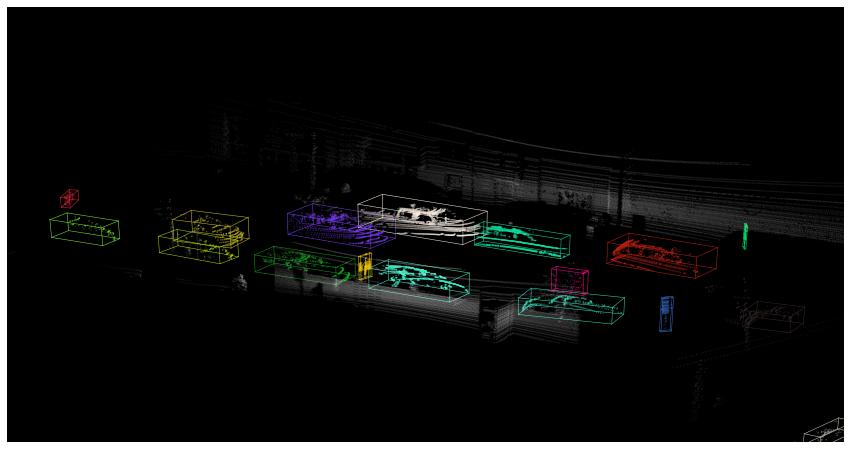

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import argoverse.visualization.visualization_utils as viz_util
from argoverse.evaluation.competition_util import get_polygon_from_points, poly_to_label

from sklearn.cluster import DBSCAN

clustering_car = DBSCAN(eps=0.7, min_samples=15, leaf_size=15).fit(driveable_area_pts)
clustering_people = DBSCAN(eps=1, min_samples=5, leaf_size=15).fit(non_driveable_area_pts)

core_samples_mask_car = np.zeros_like(clustering_car.labels_, dtype=bool)
core_samples_mask_car[clustering_car.core_sample_indices_] = True
labels_car = clustering_car.labels_

core_samples_mask_people = np.zeros_like(clustering_people.labels_, dtype=bool)
core_samples_mask_people[clustering_people.core_sample_indices_] = True
labels_people = clustering_people.labels_


point_size = 0.3

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection='3d')
unique_labels_car = set(labels_car)
colors = [np.random.rand(3,) for i in np.linspace(0, 1, len(unique_labels_car))]
for k, col in zip(unique_labels_car, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask_car = (labels_car == k)
    xyz = driveable_area_pts[class_member_mask_car & core_samples_mask_car]
    if len(xyz) > 20:
        poly = get_polygon_from_points(xyz)
        label = poly_to_label(poly)
        if label.length < 7 and label.length > 1 and label.height < 2.5:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker=".", s=point_size)
            viz_util.draw_box(ax, label.as_3d_bbox().T, axes=[0, 1, 2], color=col)
        else:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[[1,1,1,1]], marker=".", s=0.01)
            

unique_labels_people = set(labels_people)
colors = [np.random.rand(3,) for i in np.linspace(0, 1, len(unique_labels_people))]
for k, col in zip(unique_labels_people, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    class_member_mask_people = (labels_people == k)
    xyz = non_driveable_area_pts[class_member_mask_people & core_samples_mask_people]
    if len(xyz) > 10:
        poly = get_polygon_from_points(xyz)
        label = poly_to_label(poly)
        if label.width < 1 and label.length < 1 and label.height > 1 and label.height < 2.5:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[col], marker=".", s=point_size)
            viz_util.draw_box(ax, label.as_3d_bbox().T, axes=[0, 1, 2], color=col)
        else:
            ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=[[1,1,1,1]], marker=".", s=0.01)

ax.set_xlim3d([-10, 10])
ax.set_ylim3d([-10, 10])
ax.set_zlim3d([-3, 10])

ax.set_facecolor((0, 0, 0))
plt.axis('off')
plt.show()


We now have the the positions of likely objects in this particular frame.  For tracking, however, we need their locations in all future frames.  In this tutorial we will use a naive tracking-by-detection approach.  We will detect objects in each frame separately and then attempt to associate them into tracks.  Here we make the simplifying assumption that all objects are static in the AV frame.

So let's make a simple tracking function that will save the results to the labels folder

In [7]:
from argoverse.evaluation.competition_util import get_polygon_from_points, poly_to_label, save_label, get_objects, transform_xyz
from sklearn.cluster import DBSCAN

def tracking(argoverse_data):
    
    num_frames = argoverse_data.num_lidar_frame

    lidar_pts = argoverse_data.get_lidar(0)
    city_to_egovehicle_se3 = argoverse_data.get_pose(0)
    city_name = argoverse_data.city_name

    roi_area_pts = copy.deepcopy(lidar_pts)
    roi_area_pts = city_to_egovehicle_se3.transform_point_cloud(
        roi_area_pts
    )  # put into city coords
    roi_area_pts = am.remove_non_roi_points(roi_area_pts, city_name)
    roi_area_pts = am.remove_ground_surface(roi_area_pts, city_name)
    roi_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
        roi_area_pts
    )

    driveable_area_pts = copy.deepcopy(roi_area_pts)
    driveable_area_pts = city_to_egovehicle_se3.transform_point_cloud(
        driveable_area_pts
    )  # put into city coords
    driveable_area_pts = am.remove_non_driveable_area_points(driveable_area_pts, city_name)
    driveable_area_pts = city_to_egovehicle_se3.inverse_transform_point_cloud(
        driveable_area_pts
    )

    roi_area_pts_hashable = map(tuple,roi_area_pts)
    driveable_area_pts_hashable = map(tuple,driveable_area_pts)
    non_driveable_area_pts = np.array(list(set(roi_area_pts_hashable) - set(driveable_area_pts_hashable)))

    clustering_car = DBSCAN(eps=0.7, min_samples=15, leaf_size=15).fit(driveable_area_pts)
    clustering_people = DBSCAN(eps=1, min_samples=5, leaf_size=15).fit(non_driveable_area_pts)

    car_objects = get_objects(clustering_car,driveable_area_pts)
    people_objects = get_objects(clustering_people,non_driveable_area_pts)

    for idx in range(num_frames):
        pose = argoverse_data.get_pose(idx)
        labels = []
        for xyz, track_id in car_objects:
            #convert to the current frame coordinate
            xyz = transform_xyz(xyz,city_to_egovehicle_se3,pose)
            poly = get_polygon_from_points(xyz)
            label = poly_to_label(poly, category="VEHICLE",track_id=track_id.hex)
            labels.append(label)
        for xyz, track_id in people_objects:
            #convert to the current frame coordinate
            xyz = transform_xyz(xyz,city_to_egovehicle_se3,pose)
            poly = get_polygon_from_points(xyz)
            label = poly_to_label(poly, category="PEDESTRIAN",track_id=track_id.hex)
            labels.append(label)
        save_label(argoverse_data,labels,idx)

    print(f'found {len(car_objects)} cars, {len(people_objects)} pedestrians')

In [8]:
for argoverse_data in argoverse_loader:
    print(argoverse_data.current_log+': ',end="")
    tracking(argoverse_data)

c034ad9b-37a7-3508-9a00-7bde0f3be189: found 12 cars, 42 pedestrians
1e5d7745-c7b3-31a0-ae57-c480fcaa220e: found 34 cars, 19 pedestrians
4518c79d-10fb-300e-83bb-6174d5b24a45: found 4 cars, 1 pedestrians
028d5cb1-f74d-366c-85ad-84fde69b0fd3: found 9 cars, 12 pedestrians
1b5c73a4-402b-3139-846f-11e74ba3faed: found 14 cars, 14 pedestrians
4d027dc6-40ca-3f4a-ab88-3d8a4d8b29f6: found 10 cars, 7 pedestrians
c04e5e7e-d782-3cd4-853e-fbbb0e93456c: found 31 cars, 16 pedestrians
6725b340-0cf9-326e-a243-631ffc768df2: found 35 cars, 29 pedestrians
673e200e-944d-3b40-a447-f83353bd85ed: found 13 cars, 20 pedestrians
9407efb5-5a87-30a9-b5f7-b517242f5a37: found 25 cars, 14 pedestrians
d06df374-0924-3adc-b6c1-707df8425582: found 13 cars, 21 pedestrians
5dc52355-0757-37c8-8d73-e930ee681de3: found 3 cars, 10 pedestrians
1cf38cbe-deec-3675-9313-d736e02d1b58: found 16 cars, 13 pedestrians
08aa8ed7-386d-373e-a56a-f01444a8d7e5: found 16 cars, 22 pedestrians
764abf69-c7a0-32c3-97f5-330de68e13af: found 7 cars, 1

This is a pretty naive baseline, but it's sufficient for demonstration. 

We also release the tracking baseline used in the paper here https://github.com/tracking_baseline

## Check Data Format

To check that the data is in the correct format, make sure you can visualize the labels in the following block

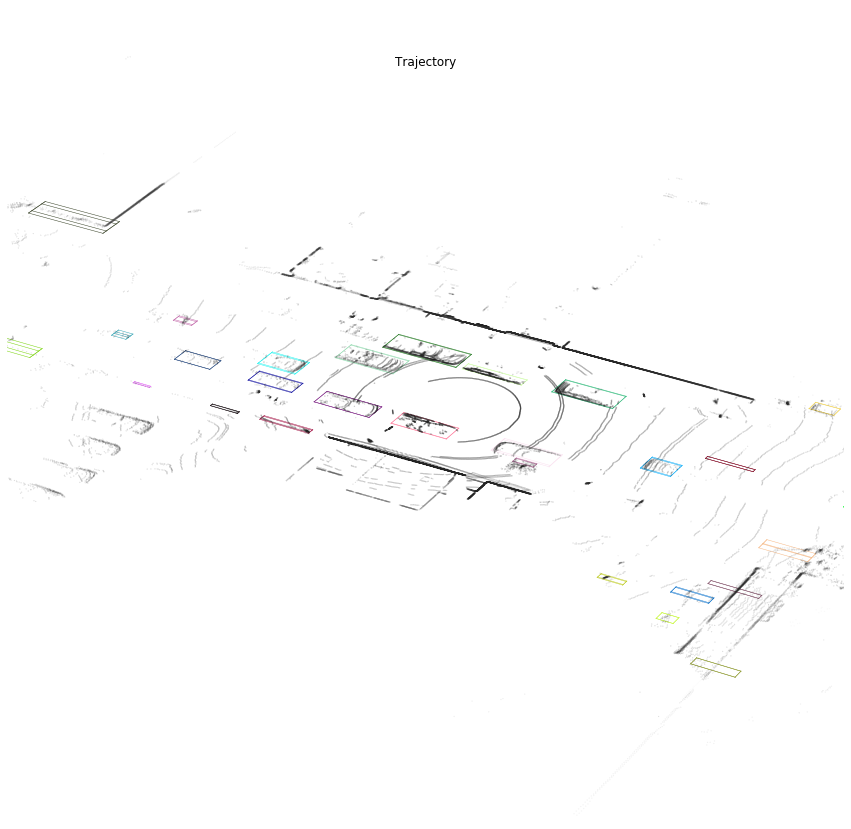

In [9]:
argoverse_loader = ArgoverseTrackingLoader(data_dir)
argoverse_data = argoverse_loader.get('9407efb5-5a87-30a9-b5f7-b517242f5a37')

#argoverse_data = argoverse_loader[0]
f3 = plt.figure(figsize=(15, 15))
ax3 = f3.add_subplot(111, projection='3d')  
idx=0 # current time frame
viz_util.draw_point_cloud_trajectory(
        ax3, 
        'Trajectory', 
        argoverse_data,idx,axes=[0, 1],xlim3d=(-15,15),ylim3d=(-15,15) # X and Y axes
    )
plt.axis('off')
plt.show()

## generate submission file

For this part, the goal is to show you how to package the results into a submission-ready file. Make sure that you have the labels in `[log_id]/per_sweep_annotations_amodal/` 

In [10]:
from argoverse.evaluation.competition_util import generate_tracking_zip

output_dir = 'competition_files/'

generate_tracking_zip(data_dir,output_dir)

You are all set!! 

Simply upload `competition_files/argoverse_tracking.zip` to our evaluation server on https://evalai.cloudcv.org/ and see how well you did it